# Gremlin examples using the air-routes data set

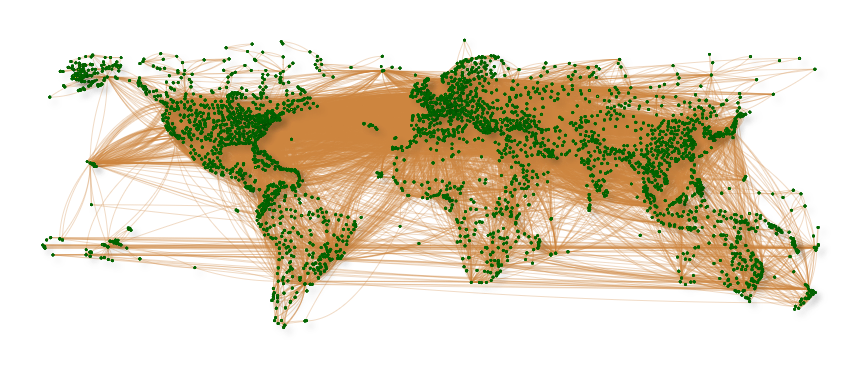

## Introduction
In this Notebook we are going to examine various Gremlin queries that explore a property graph that contains a model of the worldwide air route network. There are vertices for airports, countries and continents. There are edges between airports and between the countries,continents and airports. Each airport has a set of properties and the edges between airports have a property that represent the distance in miles.

You can find the data set along with many other samples of code and data at the following GitHub repository: https://github.com/krlawrence/graph


### Let's check our configuration and Neptune cluster status
Before we start running any queries let's first of all make sure we are connected to Neptune and that the cluster is ready. Note that `%graph_notebook_config` will return the current configuration of your notebook. If, for example, you wanted to connect to a different Amazon Neptune endpoint you could create a cell with `%%graph_notebook_config` at the top, paste the results from running `%graph_notebook_config` into it, make the required edits and run the cell. Commands that start with a single percent sign are known as **_line magics_** and commands that start with two percent signs are known as **_cell magics_**.

In [ ]:
%graph_notebook_version

In [ ]:
%graph_notebook_config

In [ ]:
%status

### Now let's load some property graph data.
The cell below makes it easy to load the air-routes data into your Neptune cluster in a form compatible with Gremlin (property graph) queries. When you run the cell you will be prompted to select a `Language` and a `Data set`. Select `Gremlin` and `airports` respectively. 

**You only need to do this once**. If you have already loaded the data previously you do not need to load it again.

In [ ]:
%seed

## Seeing a visual representation of your query

The results of any Gremlin query that returns a `path` can be explored visually. When such queries are run you will see a `Graph` tab in the query results area alongside the `Console` tab. Specific visualization features will be explained  using examples throughout this notebook. As Gremlin queries allow for `by` modulators to be used to modify the representation of `path` results, there are some rules concerning how results will be rendered visually. These rules are worth remembering. The default behavior for vertex and edge `path` results that are not modified using `by` modulators is to use their labels to annotate the visualization.

In some cases, the Neptune Notebook visualizer can figure out for itself whether an element in a `path` result represents a vertex or an edge and, in some cases, the direction the edge follows. Two simple examples of such queries are shown below. As the first query does not contain any edge information in the `path` result the edge direction cannot be determined automatically by the visualizer. 

`g.V().hasLabel('airport').out().path().limit(5)`  

In this case, the edge direction can be determined as there is an `outE` step included in the query.

`g.V().hasLabel('airport').outE().inV().path().limit(5)`

When no `by` modulators are provided, the visualizer will use the vertex and edge labels to annotate the elements of the diagram. However, when `by` modulators are used, it is not possible for the visualizer in all cases to decide on its own which path elements represent a vertex and which represent an edge. Here is an example of such a query:  

`g.V().hasLabel('airport').outE().inV().path().by('code').by('dist').limit(5)`

It is also not always possible for the visualizer to decide which direction an edge follows. In this case and in the case where `by` modulators are used, the visualizer allows for some special hints to be provided to assist in producing the desired diagram.

### Query visualization hints

You can specify query visualization hints using either `-p` or `--path-pattern` after the `%%gremin` cell "magic". The syntax in general is:

`%%gremlin -p | --path-pattern <comma separated hints>`

 The names of the hints reflect the Gremlin steps most commonly used when traversing between vertices and behave accordingly. The hints used should match the corresponding Gremlin steps used in the query. The hints used can be any combination of those shown in the list below, separated by commas. The list must not contain any spaces between the commas.

- v
- inv
- outv
- e
- ine
- oute



We can provide visualization hints for the query shown earlier as follows:

`%%gremlin -p v,oute,inv`  
`g.V().hasLabel('airport').outE().inV().path().by('code').by('dist').limit(5)`

You will find that query in the cell below. Try running it with and without the hints present and observe the differences to the visualization by selecting the `Graph` tab. Notice that without the hint the visualizer is unable to determine if the `dist` property relates to a vertex or an edge and therefore defaults to using a vertex.

### Adjusting the visualization layout and other settings
You can further adjust many of the visualization settings using the two commands

- `%graph_notebook_vis_options`
- `%%graph_notebook_vis_options`

There are examples of how to use these settings and links to additional documentation at the bottom of this notebook.

In [ ]:
%%gremlin -p v,oute,inv
g.V().hasLabel('airport').outE().inV().path().by('code').by('dist').limit(5)

## Example Gremlin Queries
The notebook cells that follow contain various queries that showcase both features of the Gremlin query language and features of the Amazon Neptune Notebooks.

### Let's find out a bit about the vertices and edges in the graph
Each vertex has a label that essentially gives it a type.

In [ ]:
%%gremlin
g.V().groupCount().by(label).unfold()

As with vertices, every edge has a label.

In [ ]:
%%gremlin
g.E().groupCount().by(label).unfold()

### Find all routes from Cozumel (CZM)
Try running the query below and clicking on the Graph tab to see the route map for flights from Cozumel. As `by`  modulators are used to return the airport code, the resultant path that you can see under the Console tab, does not have any information in it that can be used to figure out which direction the path is in. To help with the visualization provided under the Graph tab, a hint can be provided to tell the notebook how you would like the edges to be drawn and where you want the arrows placed. In this case a hint of `-p v,inv` is used. This informs the rendering algorithm that the path has an initial vertex that is connected to other vertices by outgoing edges. The hint notation mirrors that used by the corresponding Gremlin steps hence `v,inv` means there is a starting vertex connected by outgoing edges to other vertices (in Gremlin terminology an incoming vertex is what you find at the end of an outgoing edge). If you remove the hint and run the query again you will see that the arrows disappear as there is not enough information in the path result to determine the direction of the edges. To specify this hint you can either use `-p` or `--path-pattern`. The hint is only applicable in cases where the result generated is a `path`. Only queries that return a `path` will cause a visual rendering to be offered.

In [ ]:
%%gremlin -p v,inv
g.V().hasLabel('airport').has('code','CZM').out('route').path().by('code')

We can also use a shorthand form of the `has` step to achieve the same results as the prior query.

In [ ]:
%%gremlin -p v,inv
g.V().has('airport','code','CZM').out('route').path().by('code')

Let's run the same query but this time return the city name

In [ ]:
%%gremlin -p v,inv
g.V().has('airport','code','CZM').out('route').path().by('city')

### Using the details view
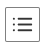

Run the query below, select the Graph tab, select a node in the graph and click on the details button (the one with three .- one above the other). As you select different vertices the details view window will update. This is useful when you want to explore lots of properties for multiple vertices using the Graph view.

In [ ]:
%%gremlin
g.V().has('airport','code','CZM').
  out('route').
  path().
    by(valueMap('code','city','region','desc','lat','lon').
       order(local).
         by(keys))

### How long are the routes from Cozumel?
In order to find the distance of a route we need to look at the edge properties. This requires us to include an `outE` step in the query. You will see this used again later and explained in more detail near the end of this notebook. The results are ordered by ascending distance. This query has been spread out over several lines and indented to aid readability. In general, for longer Gremlin queries, spreading the steps out over multiple lines in this way helps both readers and maintainers of your work more quickly see what is going on.

In [ ]:
%%gremlin -p v,oute,inv
g.V().
  has('airport','code','CZM').
  outE('route').as('a').
  inV().
  order().
    by(select('a').values('dist')).
  path().
    by('code').
    by('dist')

### Exploring countries
The query below finds the countries in the graph. You can use the Search box to find a country quickly after running the query. The results are ordered in ascending order by country name.

In [ ]:
%%gremlin
g.V().hasLabel('country').
  order().by('desc').
  local(
    values('code','desc').
    fold())

### Exploring countries and airports
The query below selects five countries at random and finds all the airports located in those countries. Each time you run the query you should see different results. Try looking at the graph by clicking on the Graph tab. If you want to see a few more countries in the results you can increase the value used by the `sample` step. You can also zoom the visualization in and out by clicking on the + and - icons.

**Clicking on the fullscreen icon in the Graph view will increase the size of the canvas.**
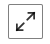

In [ ]:
%%gremlin -p v,inv
g.V().hasLabel('country').
  sample(5).
  out('contains').
  path().
    by('desc')
  

We can rewrite the query to produce a result that has all the airports grouped with  their country using a `project` step. This time the code rather than the full name for each airport is used.

In [ ]:
%%gremlin
g.V().hasLabel('country').
  sample(5).
  project('country','airports').
    by('desc').
    by(out('contains').values('code').fold())

  

### Find all airports in the United Kingdom (UK)
The query below finds the vertex representing the United Kingdom in the graph and from there finds all of the airports connected to it by 'contains' edges. The results are sorted in ascending order using the airport code.

In [ ]:
%%gremlin

g.V().has('country','code','UK').
  out('contains').
  order().
    by('code').
  project('code','desc').
    by('code').
    by('desc')



### Which airports have the most routes?
In this query we find out how many outgoing routes each airport has and create a group where the key is the airport code and the value is the number of routes. We then sort that group in descending order and return the top 20 results. Try changing the value of the `limit` step to see more or less results. Once again, note how the query has been split over multiple lines and indented to aid readability.

In [ ]:
%%gremlin
g.V().hasLabel('airport').
  group().
    by('code').
    by(out().count()).
  order(local).
    by(values,desc).
  unfold().
  limit(20)

The query below shows a different way to find the airports with the most routes and uses a `project` step to produce the final results. This time the city name rather than the airport code is used in the output.

In [ ]:
%%gremlin
g.V().hasLabel('airport').
  order().
    by(out().count(),desc).
    limit(20).
    project("Airport","Routes").
      by('city').
      by(out().count())
  

### Let's find some routes from Austin (AUS) to Wellington (WLG)
The query below uses a `repeat` step to find five routes from Austin in the United States to Wellington in New Zealand.

In [ ]:
%%gremlin -p v,inv,inv,inv
g.V().has('airport','code','AUS').
  repeat(out().simplePath()).
  until(has('code','WLG')).
  limit(5).
  path().
    by('code')

To also retrieve the distance between airports we need to inspect some edge properties. We can do that by replacing `out()` with `outE().inV()` which you can read as "look at outgoing edges and the vertices at the other end of the edge". When you run the query below you will see edges in the result. In the next query we will retrieve the distances from those edges and improve the way that vertices are labelled. If you click on the Graph tab you will see that the visualizer has used the vertex and edge labels to annotate the diagram as no `by` modulators were provided in the query.

In [ ]:
%%gremlin -p v,oute,inv,oute,inv,oute,inv
g.V().has('airport','code','AUS').
  repeat(outE().inV().simplePath()).
  until(has('code','WLG')).
  limit(5).
  path()


### Finding the total distance of selected routes
Now we have the edge results in the query we can retrieve the distances.

In [ ]:
%%gremlin -p v,oute,inv,oute,inv,oute,inv
g.V().has('airport','code','AUS').
  repeat(outE().inV().simplePath()).
  until(has('code','WLG')).
  limit(5).
  path().
    by('code').
    by('dist')


Putting everything together we can introduce a `sack` step to track the total distance of each route found.

In [ ]:
%%gremlin
g.withSack(0).
  V().
  has('airport','code','AUS').
  repeat(
    outE().sack(sum).by('dist').
    inV().simplePath()).
  until(has('code','WLG')).
  limit(5).
  order().
    by(sack()).
  local(
    union(
      path().
        by('code').
        by('dist').
        unfold(),
      sack()).
      fold())


### Where can I fly to from Santa Fe, New Mexico, nonstop?

The query below finds the cities you can fly to nonstop from Santa Fe, New Mexico.

In [ ]:
%%gremlin
g.V().
  has('code','SAF').
  out('route').
  values('code')

### Where can I fly to from Santa Fe, New Mexico, with one stop?
We can modify the previous query to answer the question "How many places can you get to from Santa Fe, New Mexico, with one stop but excluding the places you can get to nonstop?". If you remove the line containing the `where` step you will see the result goes up by four which is the number of airports we found in the previous query. The `simplePath` step also guarantees that we do not include flights back to Santa Fe in the results.

In [ ]:
%%gremlin

g.V().
  has('code','SAF').
  out('route').
  aggregate('one').
  out().
  simplePath().
  where(without('one')).
  dedup().
  count() 

Rather than just counting the places, we can change the query to list all of the city names.

In [ ]:
%%gremlin

g.V().
  has('code','SAF').
  out('route').
  aggregate('one').
  out().
  simplePath().
  where(without('one')).
  dedup().
  values('city').
  order()

### What is the minimum number of stops needed to get from Austin (AUS) to Agra (AGR) ?
The query below looks to see if you can get from Austin to Agra with 1 stop. You could also use a `times` step to do this but the use of `loops` allows us to be a little more sophisticated. If you run the query as-is you will get no results as you cannot get from AUS to AGR with just one stop. Try changing the values used by the `is` step to 3 and then 4 and re-running the query each time. You will notice that we are able to answer the question "Can I get to Agra from Austin with 2 or 3 stops?". The query ends once 10 results have been found or the loop counter reaches the target specified by the `is` step.

In [ ]:
%%gremlin -p v,inv,inv,inv,inv
g.V().
  has('airport','code','AUS').
  repeat(out('route').simplePath()).
  until(has('code','AGR').or().loops().is(2)).
  has('code','AGR').
  limit(10).
  path().by('code')

### Flights from New Zealand to Australia
The query below looks for any flights originating in New Zealand and terminating in Australia.

In [ ]:
%%gremlin -p v,inv
g.V().has('country','NZ').out('route').has('country','AU').path().by('city')

### Examining a slightly larger result set visually
The query below retrieves a selection of routes from the graph. If you click on the Graph tab you will see the vertices and edges. You may want to zoom in and out (using the scroll wheel on your mouse or the zoom gesture on your touchpad) and also pan the drawing by holding down the left mouse button while the pointer is not over a vertex or an edge and dragging. You can also move vertices around if they are overlapping by dragging them. Switching to the fullscreen view is also helpful when there are a lot of results to explore. You can also zoom the visualization in and out by clicking on the + and - icons. 

To see even more results try changing the value used by the `limit` step from 200 to 300 or 400.

In [ ]:
%%gremlin -p v,oute,inv
g.V().outE().inV().path().by('code').by().limit(200)

The next query also produces a result that is fun to explore using the `Graph` tab.

In [ ]:
%%gremlin -p v,inv,inv,inv,inv
g.V().
  has('code','AUS').
  repeat(out().where(without('x')).store('x')).
  times(4).
  limit(50).
  path().
    by('code')

## Changing the visualization settings
The Amazon Neptune Notebooks use an open source library called [Vis.js](https://github.com/visjs) to assist with drawing the graph diagrams. Vis.js provides a rich set of customizable settings. The documentation for most of the visualization settings used in this notebook can be found [here](https://visjs.org/) and in particular the graph network drawing documentation can be found [here](https://visjs.github.io/vis-network/docs/network/).  

To see the current settings used by your notebook you can use the `%graph_notebook_vis_options` line magic command. Try running the cell below.  

To change any of these settings create a new cell and use `%%graph_notebook_vis_options` to change them (note the two percent signs indicating a cell magic).

These settings give you a lot of flexibility to customize your visualizations in whichever way you find most pleasing.

In [ ]:
%graph_notebook_vis_options

### Producing a hierarchical diagram
For some types of query using a hierarchical view is quite pleasing. Try running the cell below to change a few settings and then run the next cell that demonstrates the changes. There is another cell after that one you can use to restore the default settings.

In [ ]:
%%graph_notebook_vis_options
{
  "nodes": {
    "borderWidthSelected": 0,
    "borderWidth": 0,
    "color": {
      "background": "rgba(210, 229, 255, 1)",
      "border": "transparent",
      "highlight": {
        "background": "rgba(9, 104, 178, 1)",
        "border": "rgba(8, 62, 100, 1)"
      }
    },
    "shadow": {
      "enabled": false
    },
    "shape": "circle",
    "widthConstraint": {
      "minimum": 70,
      "maximum": 70
    },
    "font": {
      "face": "courier new",
      "color": "black",
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": true,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "hierarchicalRepulsion": {
      "centralGravity": 0
    },
    "minVelocity": 0.75,
    "solver": "hierarchicalRepulsion"
  },
  "layout": {
    "hierarchical": { 
      "enabled": true,
      "direction": "LR",
      "sortMethod": "directed",
      "edgeMinimization":false }
  }
}


Run the query in the cell below to see the results of changing to a hierarchical network view.

In [ ]:
%%gremlin -p v,inv,inv,inv
g.V().
  has('code','AUS').
  repeat(out().simplePath()).
  until(has('code','WLG')).
  path().by('code').
  limit(5)

### Restore default settings
Running the cell below will return all visualization settings to their default values. However you can also use the command `%graph_notebook_vis_options reset` instead. 

In [ ]:
%%graph_notebook_vis_options
{
  "nodes": {
    "borderWidthSelected": 0,
    "borderWidth": 0,
    "color": {
      "background": "rgba(210, 229, 255, 1)",
      "border": "transparent",
      "highlight": {
        "background": "rgba(9, 104, 178, 1)",
        "border": "rgba(8, 62, 100, 1)"
      }
    },
    "shadow": {
      "enabled": false
    },
    "shape": "circle",
    "widthConstraint": {
      "minimum": 70,
      "maximum": 70
    },
    "font": {
      "face": "courier new",
      "color": "black",
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": true,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "minVelocity": 0.75,
    "barnesHut": {
      "centralGravity": 0.1,
      "gravitationalConstant": -50450,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.1
    },
    "solver": "barnesHut",
    "enabled": true,
    "adaptiveTimestep": true,
    "stabilization": {
      "enabled": true,
      "iterations": 1
    }
  }
}


### Seeing more data
If you run the cell below, the notebook will use as much of the browser window (width wise) as it can

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))